**Run this code on google colab and and first of all mount on specific folder**

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/track')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/track


In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath

In [38]:
datadir='/content/drive/MyDrive/Colab Notebooks/track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [39]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


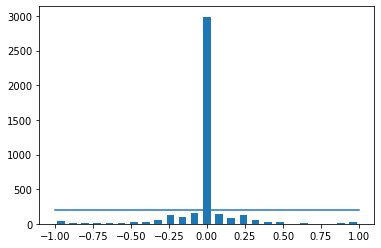

In [40]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
# make center at 0
matrix_add =(bins[:-1] + bins[1:])
center = matrix_add * 0.5
#print("center: ", center)
plt.bar(center, hist, width=0.05)

#to control bias value in steering for 0, set threshold
samples_per_bin = 200
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

total data:  4053
removed :  2790
remaining data:  1263


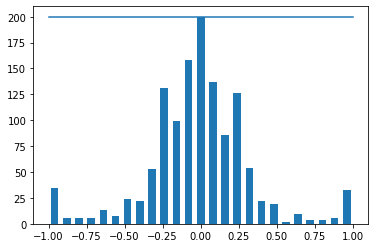

In [41]:
print('total data: ', len(data))
remove_list_ = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if (data['steering'][i] >= bins[j]) and (data['steering'][i] <= bins[j+1]):
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list_.extend(list_)
print('removed : ', len(remove_list_))
data.drop(data.index[remove_list_], inplace=True)
print('remaining data: ', len(data))

hist, bins = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.show()

In [42]:
#print(data.iloc[0])
def load_image_steering(datadir, data):
  image_path = []
  steering=[]

  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) 
    steering.append(float(indexed_data[3]))

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)

Training samples: 1010 
 Valid samples: 253


Text(0.5, 1.0, 'Validation set')

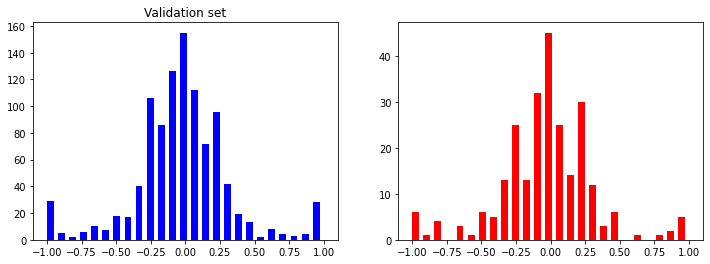

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples: {} \n Valid samples: {}'.format(len(X_train), len(X_valid)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[0].set_title('Validation set')

In [50]:
def img_preprocess(img):
  img = mpimg.imread(img)
  # delete irrelivant features from image
  img = img[60:135, :,: ] 
  # change color space to YUV because of using NVIDIA model architecture
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # apply gaussian blur for smoothing and reducing noise
  img = cv2.GaussianBlur(img, (3, 3), 0)
  # for faster computation reduce the image size
  img = cv2.resize(img, (200, 66)) # nvidia input image size
  # finally apply normalization
  img = img/255 
  return img

Text(0.5, 1.0, 'Preprocessed Image')

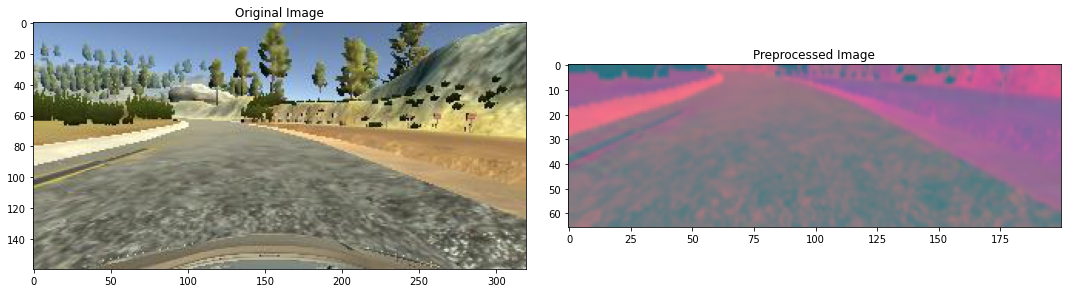

In [51]:
# test by a signle image
image = image_paths[50]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')


In [46]:
# now mapping images
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1010, 66, 200, 3)


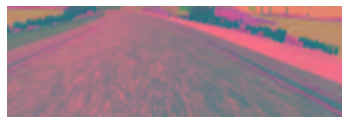

In [49]:
plt.imshow(X_train[random.randint(0, len(X_train))])
plt.axis('off')
print(X_train.shape)